# NLP Milestone 1
A notebook to preprocess youtube transcripts of Al Mokhbir Al Eqtsadi episodes.

In [ ]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
import pyarabic.araby as araby
from nltk.corpus import stopwords
import nltk

### 1. Data Loading

In [23]:
def read_episodes_files(file_path: str) -> pd.DataFrame:
    """
    Read all the episodes files in the file_path and return a DataFrame with the content of the files.
    """
    episodes_files = []
    for file in os.listdir(file_path):
        if file.endswith(".txt"):
            with open(file_path + file, 'r') as f:
                episodes_files.append(f.read())
    df = pd.DataFrame(episodes_files, columns=['episode_transcript'])
    return df

In [24]:
df = read_episodes_files('Al_Mokhbir_Al_Eqtisadi/raw_data/')
df.head()

,episode_transcript
0,عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...
1,الراجل دا أنا عمري ما شفت حد زيه قبل كدا\nتحس ...
2,في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...
3,في اواخر شهر سبتمبر سنه 2023 وزير\nالماليه الن...
4,في الساعات الاولى من صباح يوم 31 مايو\nسنه 201...


### 2. Data Understanding

In [25]:
# View number of samples
df.shape

(222, 1)

In [26]:
# View average transcript length 
df['episode_transcript'].apply(len).mean()

np.float64(14161.801801801801)

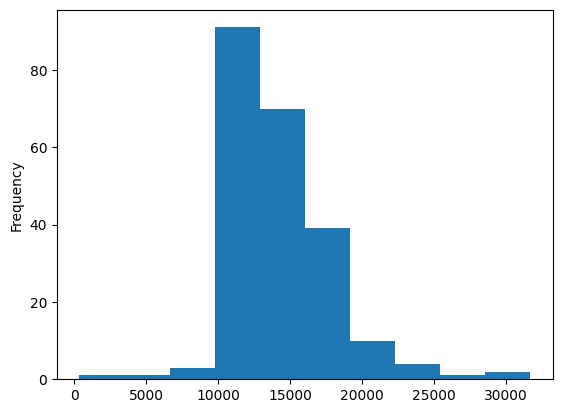

In [27]:
# View the histogram of transcript lengths
df['episode_transcript'].apply(len).plot(kind='hist')
plt.show()

In [28]:
# View a couple of samples
print(df.values[0][0])

عمان وقطر والبحرين والسعوديه دي هي الدول
العربيه الاربعه اللي زارها ملك بريطانيا
الحالي وامير ويلز السابق تشارلز الثالث
مع زوجته اميره ويلز الراحله الاميره
ديانا في نوفمبر سنه
1986 تشارلز وديانا لفوا الدول العربيه
الاربعه في رحله مدتها تسع ايام وفي
الحقيقه الرحله دي كانت اعتياديه الىى حد
كبير ما كانش في شيء مميز او مثيل
للاهتمام حواليها لحد ما فجاه بعد مرور 31
سنه الرحله دي رجعتي بقت محط اهتمام وسائل
الاعلام البريطانيه في نوفمبر 2017 صحيفه
الديلي ميل البريطانيه لقت في الارشيف
العام رساله مؤرخه بتاريخ 24 نوفمبر
1986 تشارلز كان باعتها لصديقه الكاتب
الجنوب افريقي لورانس فاندر بوست في
الرساله دي تشارلز كان بيحكي للورانس عن
زيارته للدول العربيه اللي كانت لسه
خلصانه بقى لها ايام وبيشرح له ازاي
الزياره دي ساعدته في انه يفهم بشكل افضل
وجهه نظر العرب تجاه اسرائيل المهم المهم
في السياق ده تشارلس قال لصديقه بالنص
لازم يكون في رئيس امريكي عنده الشجاعه
انه يقف في وش اللوبي اليهودي في الولايات
المتحده ويواجهه وبعدين استدرك وكتب انا
على ما اعتقد ساذج علشان افكر ان ده ممكن
يحصل طبعا الرساله دي بمجرد م

In [29]:
# Check if there are any missing values
df.isna().sum()

episode_transcript    0
dtype: int64

In [30]:
# Check if there are any duplicates
df.duplicated().sum()

np.int64(0)

In [31]:
# Check if there are very short or very long transcripts
df['transcript_length'] = df['episode_transcript'].apply(len)
df['transcript_length'].describe()

count      222.000000
mean     14161.801802
std       3645.946027
min        370.000000
25%      11721.250000
50%      13418.500000
75%      16070.500000
max      31704.000000
Name: transcript_length, dtype: float64

<Axes: ylabel='Frequency'>

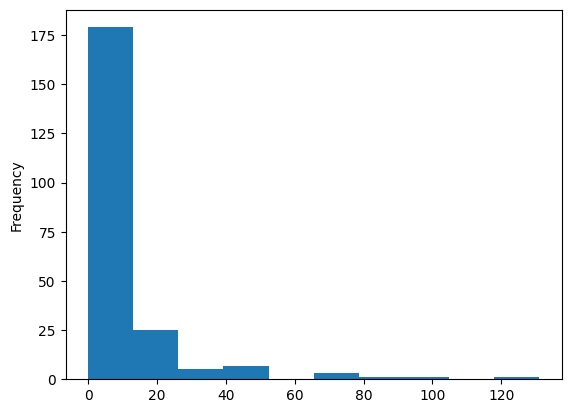

In [50]:
def count_non_arabic_words(text: str) -> int:
    """
    Count the number of non-arabic words in a text, that are also not a number
    """
    non_arabic_words = 0
    for word in text.split():
        if re.search(r'[a-zA-Z]', word):
            non_arabic_words += 1
    return non_arabic_words

# Apply the function on the DataFrame
df['non_arabic_words_count'] = df['episode_transcript'].apply(count_non_arabic_words)

# Plot the distribution of non-arabic words
df['non_arabic_words_count'].plot(kind='hist')

It can seen from the histogram that `Al Mokhbir Al Eqtisadi` uses small number of english phrases in his episodes

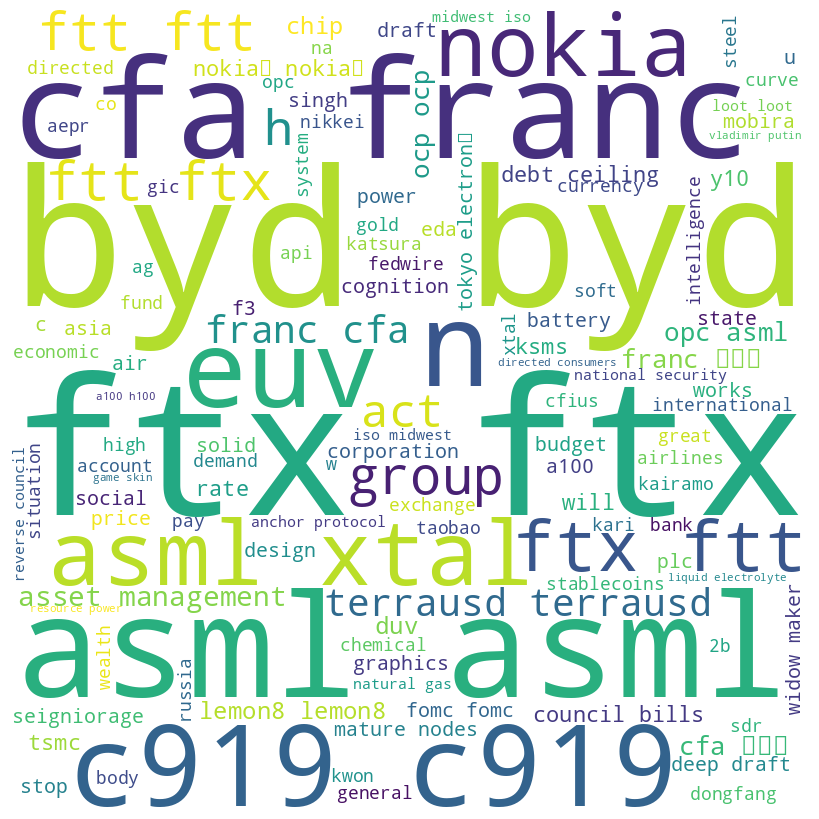

In [58]:
# Plot word cloud for the most common non-arabic words
from wordcloud import WordCloud

# Create a word cloud for the most common non-arabic words
non_arabic_words = ' '.join(df['episode_transcript'].apply(lambda x: ' '.join([word.lower() for word in x.split() if re.search(r'[a-zA-Z]', word)])))

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(non_arabic_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

It can be seen from the above word cloud that most of the english phrases used are
1. Company Names
2. Country Names
3. Buisness Expressions 
and others

### 3. Data Preprocessing & Cleaning

In [ ]:
# Cleaning function
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

def clean_arabic_txt(text: str) -> str:
    """
    Clean the Arabic text by removing any non-Arabic characters, special tags, timestamps, and stopwords.
    """
    text = re.sub(r'\[\d{2}:\d{2}:\d{2}\]', '', text)  # Remove timestamps
    text = re.sub(r'\[.*?\]', '', text) # Remove special tags like [موسيقى], [ضحك], etc.
    text = araby.strip_tashkeel(text) 
    text = araby.strip_tatweel(text) 
    text = text.strip()
    text = ' '.join([word for word in text.split() if word not in arabic_stopwords])
    return text

# Apply the cleaning function
df['cleaned_transcript'] = df['episode_transcript'].apply(clean_arabic_txt)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/karimgamaleldin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,episode_transcript,transcript_length,cleaned_transcript
0,عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...,18330,عمان وقطر والبحرين والسعوديه دي الدول العربيه ...
1,الراجل دا أنا عمري ما شفت حد زيه قبل كدا\nتحس ...,12432,الراجل دا عمري شفت حد زيه كدا تحس عبارة مزيج خ...
2,في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...,13183,سنه 1971 وزراء ماليه مجموعه الدول العشر الكبرى...
3,في اواخر شهر سبتمبر سنه 2023 وزير\nالماليه الن...,18367,اواخر شهر سنه 2023 وزير الماليه النيجيري اديبا...
4,في الساعات الاولى من صباح يوم 31 مايو\nسنه 201...,10443,الساعات الاولى يوم 31 سنه 2010 وتحديدا الساعه ...


In [33]:
print(df.values[0][2])

عمان وقطر والبحرين والسعوديه دي الدول العربيه الاربعه اللي زارها ملك بريطانيا الحالي وامير ويلز السابق تشارلز الثالث زوجته اميره ويلز الراحله الاميره ديانا سنه 1986 تشارلز وديانا لفوا الدول العربيه الاربعه رحله مدتها ايام وفي الحقيقه الرحله دي كانت اعتياديه الىى حد كبير كانش شيء مميز او مثيل للاهتمام حواليها لحد فجاه مرور 31 سنه الرحله دي رجعتي بقت محط اهتمام وسائل الاعلام البريطانيه 2017 صحيفه الديلي ميل البريطانيه لقت الارشيف العام رساله مؤرخه بتاريخ 24 1986 تشارلز باعتها لصديقه الكاتب الجنوب افريقي لورانس فاندر بوست الرساله دي تشارلز بيحكي للورانس زيارته للدول العربيه اللي كانت لسه خلصانه بقى ايام وبيشرح ازاي الزياره دي ساعدته انه يفهم بشكل افضل وجهه نظر العرب اسرائيل المهم المهم السياق ده تشارلس قال لصديقه بالنص لازم يكون رئيس امريكي عنده الشجاعه انه يقف وش اللوبي اليهودي الولايات المتحده ويواجهه وبعدين استدرك وكتب انا اعتقد ساذج علشان افكر ان ده ممكن يحصل طبعا الرساله دي بمجرد خرجت للنور قلبت الدنيا تشارلز اللي وقتها وريث العرش البريطاني وقدام الهجوم الكاسح انصار الاحتلال الاسرائي